In [211]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy

In [212]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [213]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/18 to 7/20,$0.00
1,Absol ex - 135/197,['Holofoil Market Price: '],7/21 to 7/23,$0.00
2,Absol ex - 135/197,['Holofoil Market Price: '],7/24 to 7/26,$0.00
3,Absol ex - 135/197,['Holofoil Market Price: '],7/27 to 7/29,$0.00
4,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/7 to 10/9,$0.06
12926,Zigzagoon,[' Market Price: '],10/10 to 10/12,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/10 to 10/12,$0.06
12928,Zigzagoon,[' Market Price: '],10/13 to 10/15,$0.03


In [214]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [215]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/18 to 7/20,$0.00
1,Absol ex - 135/197,Holofoil,7/21 to 7/23,$0.00
2,Absol ex - 135/197,Holofoil,7/24 to 7/26,$0.00
3,Absol ex - 135/197,Holofoil,7/27 to 7/29,$0.00
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [216]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 20% of the dataset has $0.00 market price

0.20471771075019335

In [217]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [218]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,$0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,$0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06


In [219]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [220]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
10278,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
10279,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
10280,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
10281,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [221]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

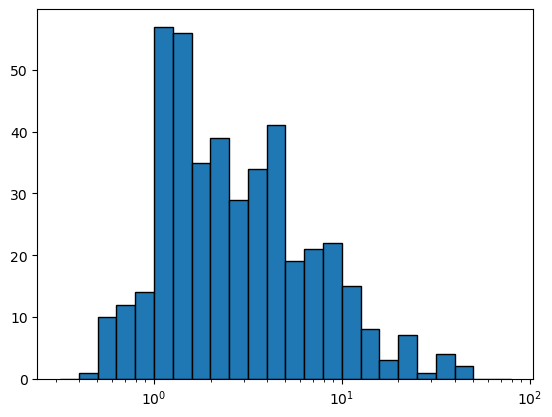

In [222]:
import matplotlib.pyplot as plt
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [223]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 54% of the initial prices are more than double the latest price in the dataset

0.541860465116279

In [224]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [225]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [226]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.07
9419,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06


In [227]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,9/25 to 9/27,0.07,0.06,0.06
9419,Zigzagoon,Reverse Holofoil,9/28 to 9/30,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06


In [228]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07
3837,Zigzagoon,Reverse Holofoil,9/7 to 9/9,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.11,0.10,0.08,0.07,0.07
3838,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07


# Data Split

In [229]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13'], dtype=object)

In [230]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
12,Absol ex - 214/197,Holofoil,8/23 to 8/25,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.82,1.81,1.92,1.65,3.37
13,Absol ex - 214/197,Holofoil,8/26 to 8/28,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.80,1.82,1.81,1.92,1.65
14,Absol ex - 214/197,Holofoil,8/29 to 8/31,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.50,1.80,1.82,1.81,1.92
15,Absol ex - 214/197,Holofoil,9/1 to 9/3,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.68,1.58,1.50,1.80,1.82,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
3834,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [231]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,Zigzagoon,Normal,9/4 to 9/6,0.04,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.05,0.06,0.06
3829,Zigzagoon,Normal,9/7 to 9/9,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.03,0.04,0.05,0.06
3830,Zigzagoon,Normal,9/10 to 9/12,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.04,0.05
3831,Zigzagoon,Normal,9/13 to 9/15,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.03,0.04


In [232]:
of_cleaned.iloc[5884]

Product         Obsidian Flames 3 Pack Blister [Eevee]
Foil                                            Normal
Date Range                                10/1 to 10/3
Market Price                                     15.01
Name: 5884, dtype: object

In [233]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [234]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [235]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [236]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,-0.572172
1,Previous Market Price_2,0.270944
2,Previous Market Price_3,-0.032726
3,Previous Market Price_4,0.005570
4,Previous Market Price_5,0.078941
5,Market Price,1.195024
6,Foil_Holofoil,-0.102611
7,Foil_Normal,-0.123918
8,Foil_Reverse Holofoil,0.226529


In [237]:
y_pred = classifier.predict(X_test)

In [238]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [239]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9883
r2:  0.9883
MAE:  0.57
MSE:  7.1737
RMSE:  2.6784


# LSTM

In [240]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [241]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
3828    0.04
3829    0.04
3830    0.04
3831    0.04
3832    0.07
Name: Market Price, Length: 1404, dtype: float64

In [242]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
model = Sequential()  
model.add(LSTM(4, input_dim=1, return_sequences=False))  
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])  

In [243]:
history = model.fit(X_train, y_train,epochs=5000)

Epoch 1/5000
44/44 [==============================] - 2s 2ms/step - loss: 1932.1123 - mean_squared_error: 1932.1123
Epoch 2/5000
44/44 [==============================] - 0s 2ms/step - loss: 1916.3893 - mean_squared_error: 1916.3893
Epoch 3/5000
44/44 [==============================] - 0s 2ms/step - loss: 1915.0156 - mean_squared_error: 1915.0156
Epoch 4/5000
44/44 [==============================] - 0s 2ms/step - loss: 1912.9252 - mean_squared_error: 1912.9252
Epoch 5/5000
44/44 [==============================] - 0s 2ms/step - loss: 1905.5668 - mean_squared_error: 1905.5668
Epoch 6/5000
44/44 [==============================] - 0s 2ms/step - loss: 1900.3466 - mean_squared_error: 1900.3466
Epoch 7/5000
44/44 [==============================] - 0s 2ms/step - loss: 1896.7361 - mean_squared_error: 1896.7361
Epoch 8/5000
44/44 [==============================] - 0s 2ms/step - loss: 1895.4570 - mean_squared_error: 1895.4570
Epoch 9/5000
44/44 [==============================] - 0s 2ms/step - loss

44/44 [==============================] - 0s 2ms/step - loss: 1815.0531 - mean_squared_error: 1815.0531
Epoch 72/5000
44/44 [==============================] - 0s 2ms/step - loss: 1814.0874 - mean_squared_error: 1814.0874
Epoch 73/5000
44/44 [==============================] - 0s 2ms/step - loss: 1812.9758 - mean_squared_error: 1812.9758
Epoch 74/5000
44/44 [==============================] - 0s 2ms/step - loss: 1812.0311 - mean_squared_error: 1812.0311
Epoch 75/5000
44/44 [==============================] - 0s 2ms/step - loss: 1811.0201 - mean_squared_error: 1811.0201
Epoch 76/5000
44/44 [==============================] - 0s 2ms/step - loss: 1810.0059 - mean_squared_error: 1810.0059
Epoch 77/5000
44/44 [==============================] - 0s 2ms/step - loss: 1809.1440 - mean_squared_error: 1809.1440
Epoch 78/5000
44/44 [==============================] - 0s 2ms/step - loss: 1808.1451 - mean_squared_error: 1808.1451
Epoch 79/5000
44/44 [==============================] - 0s 2ms/step - loss: 180

44/44 [==============================] - 0s 2ms/step - loss: 1749.9054 - mean_squared_error: 1749.9054
Epoch 141/5000
44/44 [==============================] - 0s 2ms/step - loss: 1749.0610 - mean_squared_error: 1749.0610
Epoch 142/5000
44/44 [==============================] - 0s 2ms/step - loss: 1748.1548 - mean_squared_error: 1748.1548
Epoch 143/5000
44/44 [==============================] - 0s 2ms/step - loss: 1747.1940 - mean_squared_error: 1747.1940
Epoch 144/5000
44/44 [==============================] - 0s 2ms/step - loss: 1746.2527 - mean_squared_error: 1746.2527
Epoch 145/5000
44/44 [==============================] - 0s 2ms/step - loss: 1745.2640 - mean_squared_error: 1745.2640
Epoch 146/5000
44/44 [==============================] - 0s 2ms/step - loss: 1744.3384 - mean_squared_error: 1744.3384
Epoch 147/5000
44/44 [==============================] - 0s 2ms/step - loss: 1743.4154 - mean_squared_error: 1743.4154
Epoch 148/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1691.2279 - mean_squared_error: 1691.2279
Epoch 210/5000
44/44 [==============================] - 0s 2ms/step - loss: 1690.4275 - mean_squared_error: 1690.4275
Epoch 211/5000
44/44 [==============================] - 0s 2ms/step - loss: 1689.6078 - mean_squared_error: 1689.6078
Epoch 212/5000
44/44 [==============================] - 0s 2ms/step - loss: 1688.6952 - mean_squared_error: 1688.6952
Epoch 213/5000
44/44 [==============================] - 0s 2ms/step - loss: 1688.0034 - mean_squared_error: 1688.0034
Epoch 214/5000
44/44 [==============================] - 0s 2ms/step - loss: 1687.1672 - mean_squared_error: 1687.1672
Epoch 215/5000
44/44 [==============================] - 0s 2ms/step - loss: 1686.2985 - mean_squared_error: 1686.2985
Epoch 216/5000
44/44 [==============================] - 0s 2ms/step - loss: 1685.4725 - mean_squared_error: 1685.4725
Epoch 217/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1636.9840 - mean_squared_error: 1636.9840
Epoch 279/5000
44/44 [==============================] - 0s 2ms/step - loss: 1636.2861 - mean_squared_error: 1636.2861
Epoch 280/5000
44/44 [==============================] - 0s 2ms/step - loss: 1635.5356 - mean_squared_error: 1635.5356
Epoch 281/5000
44/44 [==============================] - 0s 2ms/step - loss: 1634.7233 - mean_squared_error: 1634.7233
Epoch 282/5000
44/44 [==============================] - 0s 2ms/step - loss: 1633.9011 - mean_squared_error: 1633.9011
Epoch 283/5000
44/44 [==============================] - 0s 2ms/step - loss: 1633.1646 - mean_squared_error: 1633.1646
Epoch 284/5000
44/44 [==============================] - 0s 2ms/step - loss: 1632.4327 - mean_squared_error: 1632.4327
Epoch 285/5000
44/44 [==============================] - 0s 2ms/step - loss: 1631.6238 - mean_squared_error: 1631.6238
Epoch 286/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1586.8730 - mean_squared_error: 1586.8730
Epoch 348/5000
44/44 [==============================] - 0s 2ms/step - loss: 1586.2667 - mean_squared_error: 1586.2667
Epoch 349/5000
44/44 [==============================] - 0s 2ms/step - loss: 1585.6191 - mean_squared_error: 1585.6191
Epoch 350/5000
44/44 [==============================] - 0s 2ms/step - loss: 1584.9399 - mean_squared_error: 1584.9399
Epoch 351/5000
44/44 [==============================] - 0s 2ms/step - loss: 1584.2659 - mean_squared_error: 1584.2659
Epoch 352/5000
44/44 [==============================] - 0s 2ms/step - loss: 1583.4500 - mean_squared_error: 1583.4500
Epoch 353/5000
44/44 [==============================] - 0s 2ms/step - loss: 1582.8746 - mean_squared_error: 1582.8746
Epoch 354/5000
44/44 [==============================] - 0s 2ms/step - loss: 1582.1804 - mean_squared_error: 1582.1804
Epoch 355/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1539.4550 - mean_squared_error: 1539.4550
Epoch 417/5000
44/44 [==============================] - 0s 2ms/step - loss: 1538.7438 - mean_squared_error: 1538.7438
Epoch 418/5000
44/44 [==============================] - 0s 2ms/step - loss: 1538.0903 - mean_squared_error: 1538.0903
Epoch 419/5000
44/44 [==============================] - 0s 2ms/step - loss: 1537.5472 - mean_squared_error: 1537.5472
Epoch 420/5000
44/44 [==============================] - 0s 2ms/step - loss: 1536.7087 - mean_squared_error: 1536.7087
Epoch 421/5000
44/44 [==============================] - 0s 2ms/step - loss: 1536.1008 - mean_squared_error: 1536.1008
Epoch 422/5000
44/44 [==============================] - 0s 2ms/step - loss: 1535.5150 - mean_squared_error: 1535.5150
Epoch 423/5000
44/44 [==============================] - 0s 2ms/step - loss: 1534.9025 - mean_squared_error: 1534.9025
Epoch 424/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1494.5372 - mean_squared_error: 1494.5372
Epoch 486/5000
44/44 [==============================] - 0s 2ms/step - loss: 1493.8179 - mean_squared_error: 1493.8179
Epoch 487/5000
44/44 [==============================] - 0s 2ms/step - loss: 1493.3740 - mean_squared_error: 1493.3740
Epoch 488/5000
44/44 [==============================] - 0s 2ms/step - loss: 1492.9075 - mean_squared_error: 1492.9075
Epoch 489/5000
44/44 [==============================] - 0s 2ms/step - loss: 1492.0437 - mean_squared_error: 1492.0437
Epoch 490/5000
44/44 [==============================] - 0s 2ms/step - loss: 1491.3953 - mean_squared_error: 1491.3953
Epoch 491/5000
44/44 [==============================] - 0s 2ms/step - loss: 1490.7800 - mean_squared_error: 1490.7800
Epoch 492/5000
44/44 [==============================] - 0s 2ms/step - loss: 1490.1143 - mean_squared_error: 1490.1143
Epoch 493/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1452.2367 - mean_squared_error: 1452.2367
Epoch 555/5000
44/44 [==============================] - 0s 2ms/step - loss: 1451.4487 - mean_squared_error: 1451.4487
Epoch 556/5000
44/44 [==============================] - 0s 2ms/step - loss: 1450.7637 - mean_squared_error: 1450.7637
Epoch 557/5000
44/44 [==============================] - 0s 2ms/step - loss: 1450.1989 - mean_squared_error: 1450.1989
Epoch 558/5000
44/44 [==============================] - 0s 2ms/step - loss: 1449.7745 - mean_squared_error: 1449.7745
Epoch 559/5000
44/44 [==============================] - 0s 2ms/step - loss: 1449.0814 - mean_squared_error: 1449.0814
Epoch 560/5000
44/44 [==============================] - 0s 2ms/step - loss: 1448.5208 - mean_squared_error: 1448.5208
Epoch 561/5000
44/44 [==============================] - 0s 2ms/step - loss: 1447.7629 - mean_squared_error: 1447.7629
Epoch 562/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1411.5067 - mean_squared_error: 1411.5067
Epoch 624/5000
44/44 [==============================] - 0s 2ms/step - loss: 1410.8439 - mean_squared_error: 1410.8439
Epoch 625/5000
44/44 [==============================] - 0s 2ms/step - loss: 1410.1980 - mean_squared_error: 1410.1980
Epoch 626/5000
44/44 [==============================] - 0s 2ms/step - loss: 1409.6305 - mean_squared_error: 1409.6305
Epoch 627/5000
44/44 [==============================] - 0s 2ms/step - loss: 1409.1670 - mean_squared_error: 1409.1670
Epoch 628/5000
44/44 [==============================] - 0s 2ms/step - loss: 1408.7609 - mean_squared_error: 1408.7609
Epoch 629/5000
44/44 [==============================] - 0s 2ms/step - loss: 1408.0294 - mean_squared_error: 1408.0294
Epoch 630/5000
44/44 [==============================] - 0s 2ms/step - loss: 1407.3584 - mean_squared_error: 1407.3584
Epoch 631/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1372.6521 - mean_squared_error: 1372.6521
Epoch 693/5000
44/44 [==============================] - 0s 2ms/step - loss: 1371.8394 - mean_squared_error: 1371.8394
Epoch 694/5000
44/44 [==============================] - 0s 2ms/step - loss: 1371.3186 - mean_squared_error: 1371.3186
Epoch 695/5000
44/44 [==============================] - 0s 2ms/step - loss: 1370.9358 - mean_squared_error: 1370.9358
Epoch 696/5000
44/44 [==============================] - 0s 2ms/step - loss: 1370.3778 - mean_squared_error: 1370.3778
Epoch 697/5000
44/44 [==============================] - 0s 2ms/step - loss: 1369.8485 - mean_squared_error: 1369.8485
Epoch 698/5000
44/44 [==============================] - 0s 2ms/step - loss: 1369.2515 - mean_squared_error: 1369.2515
Epoch 699/5000
44/44 [==============================] - 0s 2ms/step - loss: 1368.6478 - mean_squared_error: 1368.6478
Epoch 700/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1335.2959 - mean_squared_error: 1335.2959
Epoch 762/5000
44/44 [==============================] - 0s 2ms/step - loss: 1334.9962 - mean_squared_error: 1334.9962
Epoch 763/5000
44/44 [==============================] - 0s 2ms/step - loss: 1334.0969 - mean_squared_error: 1334.0969
Epoch 764/5000
44/44 [==============================] - 0s 2ms/step - loss: 1333.6611 - mean_squared_error: 1333.6611
Epoch 765/5000
44/44 [==============================] - 0s 2ms/step - loss: 1333.1091 - mean_squared_error: 1333.1091
Epoch 766/5000
44/44 [==============================] - 0s 2ms/step - loss: 1332.5472 - mean_squared_error: 1332.5472
Epoch 767/5000
44/44 [==============================] - 0s 2ms/step - loss: 1331.8457 - mean_squared_error: 1331.8457
Epoch 768/5000
44/44 [==============================] - 0s 2ms/step - loss: 1331.4056 - mean_squared_error: 1331.4056
Epoch 769/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1300.2438 - mean_squared_error: 1300.2438
Epoch 831/5000
44/44 [==============================] - 0s 2ms/step - loss: 1299.8824 - mean_squared_error: 1299.8824
Epoch 832/5000
44/44 [==============================] - 0s 2ms/step - loss: 1299.3467 - mean_squared_error: 1299.3467
Epoch 833/5000
44/44 [==============================] - 0s 2ms/step - loss: 1298.6738 - mean_squared_error: 1298.6738
Epoch 834/5000
44/44 [==============================] - 0s 2ms/step - loss: 1298.3182 - mean_squared_error: 1298.3182
Epoch 835/5000
44/44 [==============================] - 0s 2ms/step - loss: 1297.7188 - mean_squared_error: 1297.7188
Epoch 836/5000
44/44 [==============================] - 0s 2ms/step - loss: 1297.1829 - mean_squared_error: 1297.1830
Epoch 837/5000
44/44 [==============================] - 0s 2ms/step - loss: 1296.7554 - mean_squared_error: 1296.7554
Epoch 838/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1267.5022 - mean_squared_error: 1267.5022
Epoch 900/5000
44/44 [==============================] - 0s 2ms/step - loss: 1267.0863 - mean_squared_error: 1267.0863
Epoch 901/5000
44/44 [==============================] - 0s 2ms/step - loss: 1266.5869 - mean_squared_error: 1266.5869
Epoch 902/5000
44/44 [==============================] - 0s 2ms/step - loss: 1265.9875 - mean_squared_error: 1265.9875
Epoch 903/5000
44/44 [==============================] - 0s 2ms/step - loss: 1265.4863 - mean_squared_error: 1265.4863
Epoch 904/5000
44/44 [==============================] - 0s 2ms/step - loss: 1264.9689 - mean_squared_error: 1264.9689
Epoch 905/5000
44/44 [==============================] - 0s 2ms/step - loss: 1264.9590 - mean_squared_error: 1264.9590
Epoch 906/5000
44/44 [==============================] - 0s 2ms/step - loss: 1264.0906 - mean_squared_error: 1264.0906
Epoch 907/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1235.9189 - mean_squared_error: 1235.9189
Epoch 969/5000
44/44 [==============================] - 0s 2ms/step - loss: 1235.7472 - mean_squared_error: 1235.7472
Epoch 970/5000
44/44 [==============================] - 0s 2ms/step - loss: 1235.4044 - mean_squared_error: 1235.4044
Epoch 971/5000
44/44 [==============================] - 0s 2ms/step - loss: 1234.9803 - mean_squared_error: 1234.9803
Epoch 972/5000
44/44 [==============================] - 0s 2ms/step - loss: 1234.5623 - mean_squared_error: 1234.5623
Epoch 973/5000
44/44 [==============================] - 0s 2ms/step - loss: 1234.1577 - mean_squared_error: 1234.1577
Epoch 974/5000
44/44 [==============================] - 0s 2ms/step - loss: 1233.6826 - mean_squared_error: 1233.6826
Epoch 975/5000
44/44 [==============================] - 0s 2ms/step - loss: 1233.2048 - mean_squared_error: 1233.2048
Epoch 976/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1206.2086 - mean_squared_error: 1206.2086
Epoch 1038/5000
44/44 [==============================] - 0s 2ms/step - loss: 1205.8345 - mean_squared_error: 1205.8345
Epoch 1039/5000
44/44 [==============================] - 0s 2ms/step - loss: 1205.3870 - mean_squared_error: 1205.3870
Epoch 1040/5000
44/44 [==============================] - 0s 2ms/step - loss: 1204.9873 - mean_squared_error: 1204.9873
Epoch 1041/5000
44/44 [==============================] - 0s 2ms/step - loss: 1204.4537 - mean_squared_error: 1204.4537
Epoch 1042/5000
44/44 [==============================] - 0s 2ms/step - loss: 1204.0626 - mean_squared_error: 1204.0626
Epoch 1043/5000
44/44 [==============================] - 0s 2ms/step - loss: 1203.6665 - mean_squared_error: 1203.6665
Epoch 1044/5000
44/44 [==============================] - 0s 2ms/step - loss: 1203.1831 - mean_squared_error: 1203.1831
Epoch 1045/5000
44/44 [==============================] - 0s 2ms/

Epoch 1106/5000
44/44 [==============================] - 0s 2ms/step - loss: 1176.9008 - mean_squared_error: 1176.9008
Epoch 1107/5000
44/44 [==============================] - 0s 2ms/step - loss: 1176.5040 - mean_squared_error: 1176.5040
Epoch 1108/5000
44/44 [==============================] - 0s 2ms/step - loss: 1176.0327 - mean_squared_error: 1176.0327
Epoch 1109/5000
44/44 [==============================] - 0s 2ms/step - loss: 1175.9263 - mean_squared_error: 1175.9263
Epoch 1110/5000
44/44 [==============================] - 0s 2ms/step - loss: 1175.5149 - mean_squared_error: 1175.5149
Epoch 1111/5000
44/44 [==============================] - 0s 2ms/step - loss: 1174.8573 - mean_squared_error: 1174.8573
Epoch 1112/5000
44/44 [==============================] - 0s 2ms/step - loss: 1174.3964 - mean_squared_error: 1174.3964
Epoch 1113/5000
44/44 [==============================] - 0s 2ms/step - loss: 1174.1274 - mean_squared_error: 1174.1274
Epoch 1114/5000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 1148.9396 - mean_squared_error: 1148.9396
Epoch 1175/5000
44/44 [==============================] - 0s 2ms/step - loss: 1148.2379 - mean_squared_error: 1148.2379
Epoch 1176/5000
44/44 [==============================] - 0s 2ms/step - loss: 1147.8613 - mean_squared_error: 1147.8613
Epoch 1177/5000
44/44 [==============================] - 0s 2ms/step - loss: 1147.4492 - mean_squared_error: 1147.4492
Epoch 1178/5000
44/44 [==============================] - 0s 2ms/step - loss: 1147.1392 - mean_squared_error: 1147.1392
Epoch 1179/5000
44/44 [==============================] - 0s 2ms/step - loss: 1146.6881 - mean_squared_error: 1146.6881
Epoch 1180/5000
44/44 [==============================] - 0s 2ms/step - loss: 1146.1244 - mean_squared_error: 1146.1244
Epoch 1181/5000
44/44 [==============================] - 0s 2ms/step - loss: 1145.9270 - mean_squared_error: 1145.9270
Epoch 1182/5000
44/44 [==============================] - 0s 2ms/

Epoch 1243/5000
44/44 [==============================] - 0s 2ms/step - loss: 1120.9133 - mean_squared_error: 1120.9133
Epoch 1244/5000
44/44 [==============================] - 0s 2ms/step - loss: 1120.3700 - mean_squared_error: 1120.3700
Epoch 1245/5000
44/44 [==============================] - 0s 2ms/step - loss: 1119.7369 - mean_squared_error: 1119.7369
Epoch 1246/5000
44/44 [==============================] - 0s 2ms/step - loss: 1119.6128 - mean_squared_error: 1119.6128
Epoch 1247/5000
44/44 [==============================] - 0s 2ms/step - loss: 1119.0989 - mean_squared_error: 1119.0989
Epoch 1248/5000
44/44 [==============================] - 0s 2ms/step - loss: 1118.7437 - mean_squared_error: 1118.7437
Epoch 1249/5000
44/44 [==============================] - 0s 2ms/step - loss: 1118.3347 - mean_squared_error: 1118.3347
Epoch 1250/5000
44/44 [==============================] - 0s 2ms/step - loss: 1117.9003 - mean_squared_error: 1117.9003
Epoch 1251/5000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 1093.5472 - mean_squared_error: 1093.5472
Epoch 1312/5000
44/44 [==============================] - 0s 2ms/step - loss: 1093.3756 - mean_squared_error: 1093.3756
Epoch 1313/5000
44/44 [==============================] - 0s 2ms/step - loss: 1092.7991 - mean_squared_error: 1092.7991
Epoch 1314/5000
44/44 [==============================] - 0s 2ms/step - loss: 1092.3654 - mean_squared_error: 1092.3654
Epoch 1315/5000
44/44 [==============================] - 0s 2ms/step - loss: 1092.3878 - mean_squared_error: 1092.3878
Epoch 1316/5000
44/44 [==============================] - 0s 2ms/step - loss: 1092.0697 - mean_squared_error: 1092.0697
Epoch 1317/5000
44/44 [==============================] - 0s 2ms/step - loss: 1091.4810 - mean_squared_error: 1091.4810
Epoch 1318/5000
44/44 [==============================] - 0s 2ms/step - loss: 1090.7716 - mean_squared_error: 1090.7716
Epoch 1319/5000
44/44 [==============================] - 0s 2ms/

Epoch 1380/5000
44/44 [==============================] - 0s 2ms/step - loss: 1066.8618 - mean_squared_error: 1066.8618
Epoch 1381/5000
44/44 [==============================] - 0s 2ms/step - loss: 1066.3169 - mean_squared_error: 1066.3169
Epoch 1382/5000
44/44 [==============================] - 0s 2ms/step - loss: 1066.5835 - mean_squared_error: 1066.5835
Epoch 1383/5000
44/44 [==============================] - 0s 2ms/step - loss: 1065.6294 - mean_squared_error: 1065.6294
Epoch 1384/5000
44/44 [==============================] - 0s 2ms/step - loss: 1065.0203 - mean_squared_error: 1065.0203
Epoch 1385/5000
44/44 [==============================] - 0s 2ms/step - loss: 1065.1661 - mean_squared_error: 1065.1661
Epoch 1386/5000
44/44 [==============================] - 0s 2ms/step - loss: 1064.3422 - mean_squared_error: 1064.3422
Epoch 1387/5000
44/44 [==============================] - 0s 2ms/step - loss: 1064.7996 - mean_squared_error: 1064.7996
Epoch 1388/5000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 1040.4242 - mean_squared_error: 1040.4242
Epoch 1449/5000
44/44 [==============================] - 0s 2ms/step - loss: 1040.2279 - mean_squared_error: 1040.2279
Epoch 1450/5000
44/44 [==============================] - 0s 2ms/step - loss: 1039.8060 - mean_squared_error: 1039.8060
Epoch 1451/5000
44/44 [==============================] - 0s 2ms/step - loss: 1041.4479 - mean_squared_error: 1041.4479
Epoch 1452/5000
44/44 [==============================] - 0s 2ms/step - loss: 1038.8071 - mean_squared_error: 1038.8071
Epoch 1453/5000
44/44 [==============================] - 0s 2ms/step - loss: 1038.8212 - mean_squared_error: 1038.8212
Epoch 1454/5000
44/44 [==============================] - 0s 2ms/step - loss: 1037.7372 - mean_squared_error: 1037.7372
Epoch 1455/5000
44/44 [==============================] - 0s 2ms/step - loss: 1037.6729 - mean_squared_error: 1037.6729
Epoch 1456/5000
44/44 [==============================] - 0s 2ms/

Epoch 1517/5000
44/44 [==============================] - 0s 2ms/step - loss: 1013.8817 - mean_squared_error: 1013.8817
Epoch 1518/5000
44/44 [==============================] - 0s 2ms/step - loss: 1013.3296 - mean_squared_error: 1013.3296
Epoch 1519/5000
44/44 [==============================] - 0s 2ms/step - loss: 1012.8644 - mean_squared_error: 1012.8644
Epoch 1520/5000
44/44 [==============================] - 0s 2ms/step - loss: 1012.6912 - mean_squared_error: 1012.6912
Epoch 1521/5000
44/44 [==============================] - 0s 2ms/step - loss: 1012.0140 - mean_squared_error: 1012.0140
Epoch 1522/5000
44/44 [==============================] - 0s 2ms/step - loss: 1011.7662 - mean_squared_error: 1011.7662
Epoch 1523/5000
44/44 [==============================] - 0s 2ms/step - loss: 1011.4320 - mean_squared_error: 1011.4320
Epoch 1524/5000
44/44 [==============================] - 0s 2ms/step - loss: 1011.1305 - mean_squared_error: 1011.1305
Epoch 1525/5000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 987.9375 - mean_squared_error: 987.9375
Epoch 1587/5000
44/44 [==============================] - 0s 2ms/step - loss: 987.2145 - mean_squared_error: 987.2145
Epoch 1588/5000
44/44 [==============================] - 0s 2ms/step - loss: 986.8703 - mean_squared_error: 986.8703
Epoch 1589/5000
44/44 [==============================] - 0s 2ms/step - loss: 986.4538 - mean_squared_error: 986.4538
Epoch 1590/5000
44/44 [==============================] - 0s 2ms/step - loss: 985.9270 - mean_squared_error: 985.9270
Epoch 1591/5000
44/44 [==============================] - 0s 2ms/step - loss: 986.1061 - mean_squared_error: 986.1061
Epoch 1592/5000
44/44 [==============================] - 0s 2ms/step - loss: 985.4119 - mean_squared_error: 985.4119
Epoch 1593/5000
44/44 [==============================] - 0s 2ms/step - loss: 985.0649 - mean_squared_error: 985.0649
Epoch 1594/5000
44/44 [==============================] - 0s 2ms/step - loss: 984

44/44 [==============================] - 0s 2ms/step - loss: 961.9136 - mean_squared_error: 961.9136
Epoch 1657/5000
44/44 [==============================] - 0s 2ms/step - loss: 961.5732 - mean_squared_error: 961.5732
Epoch 1658/5000
44/44 [==============================] - 0s 2ms/step - loss: 960.7759 - mean_squared_error: 960.7759
Epoch 1659/5000
44/44 [==============================] - 0s 2ms/step - loss: 960.6764 - mean_squared_error: 960.6764
Epoch 1660/5000
44/44 [==============================] - 0s 2ms/step - loss: 960.0481 - mean_squared_error: 960.0481
Epoch 1661/5000
44/44 [==============================] - 0s 2ms/step - loss: 960.0175 - mean_squared_error: 960.0175
Epoch 1662/5000
44/44 [==============================] - 0s 2ms/step - loss: 959.3749 - mean_squared_error: 959.3749
Epoch 1663/5000
44/44 [==============================] - 0s 2ms/step - loss: 958.6420 - mean_squared_error: 958.6420
Epoch 1664/5000
44/44 [==============================] - 0s 2ms/step - loss: 958

44/44 [==============================] - 0s 2ms/step - loss: 935.9045 - mean_squared_error: 935.9045
Epoch 1727/5000
44/44 [==============================] - 0s 2ms/step - loss: 935.2321 - mean_squared_error: 935.2321
Epoch 1728/5000
44/44 [==============================] - 0s 2ms/step - loss: 936.2974 - mean_squared_error: 936.2974
Epoch 1729/5000
44/44 [==============================] - 0s 2ms/step - loss: 934.7481 - mean_squared_error: 934.7481
Epoch 1730/5000
44/44 [==============================] - 0s 2ms/step - loss: 934.7599 - mean_squared_error: 934.7599
Epoch 1731/5000
44/44 [==============================] - 0s 2ms/step - loss: 934.2883 - mean_squared_error: 934.2883
Epoch 1732/5000
44/44 [==============================] - 0s 2ms/step - loss: 933.7622 - mean_squared_error: 933.7622
Epoch 1733/5000
44/44 [==============================] - 0s 2ms/step - loss: 933.0473 - mean_squared_error: 933.0473
Epoch 1734/5000
44/44 [==============================] - 0s 2ms/step - loss: 933

44/44 [==============================] - 0s 2ms/step - loss: 911.1040 - mean_squared_error: 911.1040
Epoch 1797/5000
44/44 [==============================] - 0s 2ms/step - loss: 910.8362 - mean_squared_error: 910.8362
Epoch 1798/5000
44/44 [==============================] - 0s 2ms/step - loss: 910.6296 - mean_squared_error: 910.6296
Epoch 1799/5000
44/44 [==============================] - 0s 2ms/step - loss: 910.5555 - mean_squared_error: 910.5555
Epoch 1800/5000
44/44 [==============================] - 0s 2ms/step - loss: 909.6376 - mean_squared_error: 909.6376
Epoch 1801/5000
44/44 [==============================] - 0s 2ms/step - loss: 910.1672 - mean_squared_error: 910.1672
Epoch 1802/5000
44/44 [==============================] - 0s 2ms/step - loss: 908.9360 - mean_squared_error: 908.9360
Epoch 1803/5000
44/44 [==============================] - 0s 2ms/step - loss: 908.8323 - mean_squared_error: 908.8323
Epoch 1804/5000
44/44 [==============================] - 0s 2ms/step - loss: 908

44/44 [==============================] - 0s 2ms/step - loss: 885.2646 - mean_squared_error: 885.2646
Epoch 1867/5000
44/44 [==============================] - 0s 2ms/step - loss: 885.7333 - mean_squared_error: 885.7333
Epoch 1868/5000
44/44 [==============================] - 0s 2ms/step - loss: 886.3898 - mean_squared_error: 886.3898
Epoch 1869/5000
44/44 [==============================] - 0s 2ms/step - loss: 884.4202 - mean_squared_error: 884.4202
Epoch 1870/5000
44/44 [==============================] - 0s 2ms/step - loss: 884.0099 - mean_squared_error: 884.0099
Epoch 1871/5000
44/44 [==============================] - 0s 2ms/step - loss: 884.1104 - mean_squared_error: 884.1104
Epoch 1872/5000
44/44 [==============================] - 0s 2ms/step - loss: 883.8727 - mean_squared_error: 883.8727
Epoch 1873/5000
44/44 [==============================] - 0s 2ms/step - loss: 882.9938 - mean_squared_error: 882.9938
Epoch 1874/5000
44/44 [==============================] - 0s 2ms/step - loss: 882

44/44 [==============================] - 0s 2ms/step - loss: 861.8093 - mean_squared_error: 861.8093
Epoch 1937/5000
44/44 [==============================] - 0s 2ms/step - loss: 861.0334 - mean_squared_error: 861.0334
Epoch 1938/5000
44/44 [==============================] - 0s 2ms/step - loss: 860.6110 - mean_squared_error: 860.6110
Epoch 1939/5000
44/44 [==============================] - 0s 2ms/step - loss: 860.6691 - mean_squared_error: 860.6691
Epoch 1940/5000
44/44 [==============================] - 0s 2ms/step - loss: 860.0004 - mean_squared_error: 860.0004
Epoch 1941/5000
44/44 [==============================] - 0s 2ms/step - loss: 859.9095 - mean_squared_error: 859.9095
Epoch 1942/5000
44/44 [==============================] - 0s 2ms/step - loss: 859.6796 - mean_squared_error: 859.6796
Epoch 1943/5000
44/44 [==============================] - 0s 2ms/step - loss: 858.8878 - mean_squared_error: 858.8878
Epoch 1944/5000
44/44 [==============================] - 0s 2ms/step - loss: 858

44/44 [==============================] - 0s 2ms/step - loss: 837.1980 - mean_squared_error: 837.1980
Epoch 2007/5000
44/44 [==============================] - 0s 2ms/step - loss: 836.3336 - mean_squared_error: 836.3336
Epoch 2008/5000
44/44 [==============================] - 0s 2ms/step - loss: 837.1317 - mean_squared_error: 837.1317
Epoch 2009/5000
44/44 [==============================] - 0s 2ms/step - loss: 835.9845 - mean_squared_error: 835.9845
Epoch 2010/5000
44/44 [==============================] - 0s 2ms/step - loss: 836.2457 - mean_squared_error: 836.2457
Epoch 2011/5000
44/44 [==============================] - 0s 2ms/step - loss: 835.4266 - mean_squared_error: 835.4266
Epoch 2012/5000
44/44 [==============================] - 0s 2ms/step - loss: 835.3946 - mean_squared_error: 835.3946
Epoch 2013/5000
44/44 [==============================] - 0s 2ms/step - loss: 835.0955 - mean_squared_error: 835.0955
Epoch 2014/5000
44/44 [==============================] - 0s 2ms/step - loss: 834

44/44 [==============================] - 0s 2ms/step - loss: 813.1184 - mean_squared_error: 813.1184
Epoch 2077/5000
44/44 [==============================] - 0s 2ms/step - loss: 812.9610 - mean_squared_error: 812.9610
Epoch 2078/5000
44/44 [==============================] - 0s 2ms/step - loss: 813.9687 - mean_squared_error: 813.9687
Epoch 2079/5000
44/44 [==============================] - 0s 2ms/step - loss: 812.1641 - mean_squared_error: 812.1641
Epoch 2080/5000
44/44 [==============================] - 0s 2ms/step - loss: 811.4967 - mean_squared_error: 811.4967
Epoch 2081/5000
44/44 [==============================] - 0s 2ms/step - loss: 811.8472 - mean_squared_error: 811.8472
Epoch 2082/5000
44/44 [==============================] - 0s 2ms/step - loss: 811.0215 - mean_squared_error: 811.0215
Epoch 2083/5000
44/44 [==============================] - 0s 2ms/step - loss: 811.3658 - mean_squared_error: 811.3658
Epoch 2084/5000
44/44 [==============================] - 0s 2ms/step - loss: 810

44/44 [==============================] - 0s 2ms/step - loss: 789.5608 - mean_squared_error: 789.5608
Epoch 2147/5000
44/44 [==============================] - 0s 2ms/step - loss: 788.8412 - mean_squared_error: 788.8412
Epoch 2148/5000
44/44 [==============================] - 0s 2ms/step - loss: 788.9532 - mean_squared_error: 788.9532
Epoch 2149/5000
44/44 [==============================] - 0s 2ms/step - loss: 788.6263 - mean_squared_error: 788.6263
Epoch 2150/5000
44/44 [==============================] - 0s 2ms/step - loss: 788.0761 - mean_squared_error: 788.0761
Epoch 2151/5000
44/44 [==============================] - 0s 2ms/step - loss: 787.6794 - mean_squared_error: 787.6794
Epoch 2152/5000
44/44 [==============================] - 0s 2ms/step - loss: 788.0405 - mean_squared_error: 788.0405
Epoch 2153/5000
44/44 [==============================] - 0s 2ms/step - loss: 786.9893 - mean_squared_error: 786.9893
Epoch 2154/5000
44/44 [==============================] - 0s 2ms/step - loss: 786

44/44 [==============================] - 0s 2ms/step - loss: 765.9056 - mean_squared_error: 765.9056
Epoch 2217/5000
44/44 [==============================] - 0s 2ms/step - loss: 765.4884 - mean_squared_error: 765.4884
Epoch 2218/5000
44/44 [==============================] - 0s 2ms/step - loss: 765.3342 - mean_squared_error: 765.3342
Epoch 2219/5000
44/44 [==============================] - 0s 2ms/step - loss: 765.0501 - mean_squared_error: 765.0501
Epoch 2220/5000
44/44 [==============================] - 0s 2ms/step - loss: 764.6577 - mean_squared_error: 764.6577
Epoch 2221/5000
44/44 [==============================] - 0s 2ms/step - loss: 764.9849 - mean_squared_error: 764.9849
Epoch 2222/5000
44/44 [==============================] - 0s 2ms/step - loss: 764.2473 - mean_squared_error: 764.2473
Epoch 2223/5000
44/44 [==============================] - 0s 2ms/step - loss: 763.5900 - mean_squared_error: 763.5900
Epoch 2224/5000
44/44 [==============================] - 0s 2ms/step - loss: 763

44/44 [==============================] - 0s 2ms/step - loss: 743.5428 - mean_squared_error: 743.5428
Epoch 2287/5000
44/44 [==============================] - 0s 2ms/step - loss: 743.2999 - mean_squared_error: 743.2999
Epoch 2288/5000
44/44 [==============================] - 0s 2ms/step - loss: 743.6221 - mean_squared_error: 743.6221
Epoch 2289/5000
44/44 [==============================] - 0s 2ms/step - loss: 742.4871 - mean_squared_error: 742.4871
Epoch 2290/5000
44/44 [==============================] - 0s 2ms/step - loss: 742.2237 - mean_squared_error: 742.2237
Epoch 2291/5000
44/44 [==============================] - 0s 2ms/step - loss: 742.2589 - mean_squared_error: 742.2589
Epoch 2292/5000
44/44 [==============================] - 0s 2ms/step - loss: 741.3286 - mean_squared_error: 741.3286
Epoch 2293/5000
44/44 [==============================] - 0s 2ms/step - loss: 741.6796 - mean_squared_error: 741.6796
Epoch 2294/5000
44/44 [==============================] - 0s 2ms/step - loss: 740

44/44 [==============================] - 0s 2ms/step - loss: 720.6955 - mean_squared_error: 720.6955
Epoch 2357/5000
44/44 [==============================] - 0s 2ms/step - loss: 720.6038 - mean_squared_error: 720.6038
Epoch 2358/5000
44/44 [==============================] - 0s 2ms/step - loss: 719.8777 - mean_squared_error: 719.8777
Epoch 2359/5000
44/44 [==============================] - 0s 2ms/step - loss: 720.0186 - mean_squared_error: 720.0186
Epoch 2360/5000
44/44 [==============================] - 0s 2ms/step - loss: 719.5071 - mean_squared_error: 719.5071
Epoch 2361/5000
44/44 [==============================] - 0s 2ms/step - loss: 719.1331 - mean_squared_error: 719.1331
Epoch 2362/5000
44/44 [==============================] - 0s 2ms/step - loss: 718.8694 - mean_squared_error: 718.8694
Epoch 2363/5000
44/44 [==============================] - 0s 2ms/step - loss: 718.6267 - mean_squared_error: 718.6267
Epoch 2364/5000
44/44 [==============================] - 0s 2ms/step - loss: 717

44/44 [==============================] - 0s 2ms/step - loss: 698.6846 - mean_squared_error: 698.6846
Epoch 2427/5000
44/44 [==============================] - 0s 2ms/step - loss: 698.2218 - mean_squared_error: 698.2218
Epoch 2428/5000
44/44 [==============================] - 0s 2ms/step - loss: 698.0615 - mean_squared_error: 698.0615
Epoch 2429/5000
44/44 [==============================] - 0s 2ms/step - loss: 697.6863 - mean_squared_error: 697.6863
Epoch 2430/5000
44/44 [==============================] - 0s 2ms/step - loss: 697.3112 - mean_squared_error: 697.3112
Epoch 2431/5000
44/44 [==============================] - 0s 2ms/step - loss: 697.1906 - mean_squared_error: 697.1906
Epoch 2432/5000
44/44 [==============================] - 0s 2ms/step - loss: 697.1537 - mean_squared_error: 697.1537
Epoch 2433/5000
44/44 [==============================] - 0s 2ms/step - loss: 696.5151 - mean_squared_error: 696.5151
Epoch 2434/5000
44/44 [==============================] - 0s 2ms/step - loss: 696

44/44 [==============================] - 0s 2ms/step - loss: 677.3249 - mean_squared_error: 677.3249
Epoch 2497/5000
44/44 [==============================] - 0s 2ms/step - loss: 677.1039 - mean_squared_error: 677.1039
Epoch 2498/5000
44/44 [==============================] - 0s 2ms/step - loss: 676.4693 - mean_squared_error: 676.4693
Epoch 2499/5000
44/44 [==============================] - 0s 2ms/step - loss: 676.3679 - mean_squared_error: 676.3679
Epoch 2500/5000
44/44 [==============================] - 0s 2ms/step - loss: 675.8985 - mean_squared_error: 675.8985
Epoch 2501/5000
44/44 [==============================] - 0s 2ms/step - loss: 675.8845 - mean_squared_error: 675.8845
Epoch 2502/5000
44/44 [==============================] - 0s 2ms/step - loss: 675.3977 - mean_squared_error: 675.3977
Epoch 2503/5000
44/44 [==============================] - 0s 2ms/step - loss: 675.0573 - mean_squared_error: 675.0573
Epoch 2504/5000
44/44 [==============================] - 0s 2ms/step - loss: 674

44/44 [==============================] - 0s 2ms/step - loss: 656.5929 - mean_squared_error: 656.5929
Epoch 2567/5000
44/44 [==============================] - 0s 2ms/step - loss: 656.3221 - mean_squared_error: 656.3221
Epoch 2568/5000
44/44 [==============================] - 0s 2ms/step - loss: 655.8342 - mean_squared_error: 655.8342
Epoch 2569/5000
44/44 [==============================] - 0s 2ms/step - loss: 655.7022 - mean_squared_error: 655.7022
Epoch 2570/5000
44/44 [==============================] - 0s 2ms/step - loss: 655.6840 - mean_squared_error: 655.6840
Epoch 2571/5000
44/44 [==============================] - 0s 2ms/step - loss: 655.1176 - mean_squared_error: 655.1176
Epoch 2572/5000
44/44 [==============================] - 0s 2ms/step - loss: 655.0051 - mean_squared_error: 655.0051
Epoch 2573/5000
44/44 [==============================] - 0s 2ms/step - loss: 654.5548 - mean_squared_error: 654.5548
Epoch 2574/5000
44/44 [==============================] - 0s 2ms/step - loss: 654

44/44 [==============================] - 0s 2ms/step - loss: 635.7009 - mean_squared_error: 635.7009
Epoch 2637/5000
44/44 [==============================] - 0s 2ms/step - loss: 635.4428 - mean_squared_error: 635.4428
Epoch 2638/5000
44/44 [==============================] - 0s 2ms/step - loss: 635.4021 - mean_squared_error: 635.4021
Epoch 2639/5000
44/44 [==============================] - 0s 2ms/step - loss: 634.9032 - mean_squared_error: 634.9032
Epoch 2640/5000
44/44 [==============================] - 0s 2ms/step - loss: 634.4418 - mean_squared_error: 634.4418
Epoch 2641/5000
44/44 [==============================] - 0s 2ms/step - loss: 634.3022 - mean_squared_error: 634.3022
Epoch 2642/5000
44/44 [==============================] - 0s 2ms/step - loss: 633.9291 - mean_squared_error: 633.9291
Epoch 2643/5000
44/44 [==============================] - 0s 2ms/step - loss: 634.1144 - mean_squared_error: 634.1144
Epoch 2644/5000
44/44 [==============================] - 0s 2ms/step - loss: 633

44/44 [==============================] - 0s 2ms/step - loss: 615.4955 - mean_squared_error: 615.4955
Epoch 2707/5000
44/44 [==============================] - 0s 2ms/step - loss: 615.9451 - mean_squared_error: 615.9451
Epoch 2708/5000
44/44 [==============================] - 0s 2ms/step - loss: 615.1338 - mean_squared_error: 615.1338
Epoch 2709/5000
44/44 [==============================] - 0s 2ms/step - loss: 614.9557 - mean_squared_error: 614.9557
Epoch 2710/5000
44/44 [==============================] - 0s 2ms/step - loss: 614.4692 - mean_squared_error: 614.4692
Epoch 2711/5000
44/44 [==============================] - 0s 2ms/step - loss: 614.5112 - mean_squared_error: 614.5112
Epoch 2712/5000
44/44 [==============================] - 0s 2ms/step - loss: 613.9450 - mean_squared_error: 613.9450
Epoch 2713/5000
44/44 [==============================] - 0s 2ms/step - loss: 613.7986 - mean_squared_error: 613.7986
Epoch 2714/5000
44/44 [==============================] - 0s 2ms/step - loss: 613

44/44 [==============================] - 0s 2ms/step - loss: 595.7339 - mean_squared_error: 595.7339
Epoch 2777/5000
44/44 [==============================] - 0s 2ms/step - loss: 595.6149 - mean_squared_error: 595.6149
Epoch 2778/5000
44/44 [==============================] - 0s 2ms/step - loss: 595.1640 - mean_squared_error: 595.1640
Epoch 2779/5000
44/44 [==============================] - 0s 2ms/step - loss: 594.9081 - mean_squared_error: 594.9081
Epoch 2780/5000
44/44 [==============================] - 0s 2ms/step - loss: 594.6656 - mean_squared_error: 594.6656
Epoch 2781/5000
44/44 [==============================] - 0s 2ms/step - loss: 594.3393 - mean_squared_error: 594.3393
Epoch 2782/5000
44/44 [==============================] - 0s 2ms/step - loss: 593.9886 - mean_squared_error: 593.9886
Epoch 2783/5000
44/44 [==============================] - 0s 2ms/step - loss: 594.0912 - mean_squared_error: 594.0912
Epoch 2784/5000
44/44 [==============================] - 0s 2ms/step - loss: 593

44/44 [==============================] - 0s 2ms/step - loss: 576.5357 - mean_squared_error: 576.5357
Epoch 2847/5000
44/44 [==============================] - 0s 2ms/step - loss: 576.2476 - mean_squared_error: 576.2476
Epoch 2848/5000
44/44 [==============================] - 0s 2ms/step - loss: 575.8975 - mean_squared_error: 575.8975
Epoch 2849/5000
44/44 [==============================] - 0s 2ms/step - loss: 576.0031 - mean_squared_error: 576.0031
Epoch 2850/5000
44/44 [==============================] - 0s 2ms/step - loss: 575.3215 - mean_squared_error: 575.3215
Epoch 2851/5000
44/44 [==============================] - 0s 2ms/step - loss: 575.2881 - mean_squared_error: 575.2881
Epoch 2852/5000
44/44 [==============================] - 0s 2ms/step - loss: 574.9559 - mean_squared_error: 574.9559
Epoch 2853/5000
44/44 [==============================] - 0s 2ms/step - loss: 574.5177 - mean_squared_error: 574.5177
Epoch 2854/5000
44/44 [==============================] - 0s 2ms/step - loss: 574

44/44 [==============================] - 0s 2ms/step - loss: 557.4953 - mean_squared_error: 557.4953
Epoch 2917/5000
44/44 [==============================] - 0s 2ms/step - loss: 557.2073 - mean_squared_error: 557.2073
Epoch 2918/5000
44/44 [==============================] - 0s 2ms/step - loss: 557.0247 - mean_squared_error: 557.0247
Epoch 2919/5000
44/44 [==============================] - 0s 2ms/step - loss: 556.6976 - mean_squared_error: 556.6976
Epoch 2920/5000
44/44 [==============================] - 0s 2ms/step - loss: 556.4608 - mean_squared_error: 556.4608
Epoch 2921/5000
44/44 [==============================] - 0s 2ms/step - loss: 555.9269 - mean_squared_error: 555.9269
Epoch 2922/5000
44/44 [==============================] - 0s 2ms/step - loss: 556.1643 - mean_squared_error: 556.1643
Epoch 2923/5000
44/44 [==============================] - 0s 2ms/step - loss: 555.2474 - mean_squared_error: 555.2474
Epoch 2924/5000
44/44 [==============================] - 0s 2ms/step - loss: 555

44/44 [==============================] - 0s 2ms/step - loss: 538.5691 - mean_squared_error: 538.5691
Epoch 2987/5000
44/44 [==============================] - 0s 2ms/step - loss: 538.2825 - mean_squared_error: 538.2825
Epoch 2988/5000
44/44 [==============================] - 0s 2ms/step - loss: 538.1880 - mean_squared_error: 538.1880
Epoch 2989/5000
44/44 [==============================] - 0s 2ms/step - loss: 537.6858 - mean_squared_error: 537.6858
Epoch 2990/5000
44/44 [==============================] - 0s 2ms/step - loss: 537.9239 - mean_squared_error: 537.9239
Epoch 2991/5000
44/44 [==============================] - 0s 2ms/step - loss: 537.2407 - mean_squared_error: 537.2407
Epoch 2992/5000
44/44 [==============================] - 0s 2ms/step - loss: 536.9941 - mean_squared_error: 536.9941
Epoch 2993/5000
44/44 [==============================] - 0s 2ms/step - loss: 536.8637 - mean_squared_error: 536.8637
Epoch 2994/5000
44/44 [==============================] - 0s 2ms/step - loss: 536

44/44 [==============================] - 0s 2ms/step - loss: 520.1035 - mean_squared_error: 520.1035
Epoch 3057/5000
44/44 [==============================] - 0s 2ms/step - loss: 519.7372 - mean_squared_error: 519.7372
Epoch 3058/5000
44/44 [==============================] - 0s 2ms/step - loss: 519.5161 - mean_squared_error: 519.5161
Epoch 3059/5000
44/44 [==============================] - 0s 2ms/step - loss: 519.4917 - mean_squared_error: 519.4917
Epoch 3060/5000
44/44 [==============================] - 0s 2ms/step - loss: 519.0707 - mean_squared_error: 519.0707
Epoch 3061/5000
44/44 [==============================] - 0s 2ms/step - loss: 518.8481 - mean_squared_error: 518.8481
Epoch 3062/5000
44/44 [==============================] - 0s 2ms/step - loss: 518.4866 - mean_squared_error: 518.4866
Epoch 3063/5000
44/44 [==============================] - 0s 2ms/step - loss: 518.2300 - mean_squared_error: 518.2300
Epoch 3064/5000
44/44 [==============================] - 0s 2ms/step - loss: 518

44/44 [==============================] - 0s 2ms/step - loss: 502.0738 - mean_squared_error: 502.0738
Epoch 3127/5000
44/44 [==============================] - 0s 2ms/step - loss: 501.8973 - mean_squared_error: 501.8973
Epoch 3128/5000
44/44 [==============================] - 0s 2ms/step - loss: 501.6817 - mean_squared_error: 501.6817
Epoch 3129/5000
44/44 [==============================] - 0s 2ms/step - loss: 501.2576 - mean_squared_error: 501.2576
Epoch 3130/5000
44/44 [==============================] - 0s 2ms/step - loss: 501.0381 - mean_squared_error: 501.0381
Epoch 3131/5000
44/44 [==============================] - 0s 2ms/step - loss: 500.8474 - mean_squared_error: 500.8474
Epoch 3132/5000
44/44 [==============================] - 0s 2ms/step - loss: 500.5950 - mean_squared_error: 500.5950
Epoch 3133/5000
44/44 [==============================] - 0s 2ms/step - loss: 500.2931 - mean_squared_error: 500.2931
Epoch 3134/5000
44/44 [==============================] - 0s 2ms/step - loss: 499

44/44 [==============================] - 0s 2ms/step - loss: 485.4806 - mean_squared_error: 485.4806
Epoch 3197/5000
44/44 [==============================] - 0s 2ms/step - loss: 484.6324 - mean_squared_error: 484.6324
Epoch 3198/5000
44/44 [==============================] - 0s 2ms/step - loss: 484.5791 - mean_squared_error: 484.5791
Epoch 3199/5000
44/44 [==============================] - 0s 2ms/step - loss: 484.1030 - mean_squared_error: 484.1030
Epoch 3200/5000
44/44 [==============================] - 0s 2ms/step - loss: 484.0377 - mean_squared_error: 484.0377
Epoch 3201/5000
44/44 [==============================] - 0s 2ms/step - loss: 483.6091 - mean_squared_error: 483.6091
Epoch 3202/5000
44/44 [==============================] - 0s 2ms/step - loss: 483.4140 - mean_squared_error: 483.4140
Epoch 3203/5000
44/44 [==============================] - 0s 2ms/step - loss: 483.2978 - mean_squared_error: 483.2978
Epoch 3204/5000
44/44 [==============================] - 0s 2ms/step - loss: 482

44/44 [==============================] - 0s 2ms/step - loss: 468.1071 - mean_squared_error: 468.1071
Epoch 3267/5000
44/44 [==============================] - 0s 2ms/step - loss: 467.8009 - mean_squared_error: 467.8009
Epoch 3268/5000
44/44 [==============================] - 0s 2ms/step - loss: 467.7523 - mean_squared_error: 467.7523
Epoch 3269/5000
44/44 [==============================] - 0s 2ms/step - loss: 467.3047 - mean_squared_error: 467.3047
Epoch 3270/5000
44/44 [==============================] - 0s 2ms/step - loss: 467.1800 - mean_squared_error: 467.1800
Epoch 3271/5000
44/44 [==============================] - 0s 2ms/step - loss: 466.8067 - mean_squared_error: 466.8067
Epoch 3272/5000
44/44 [==============================] - 0s 2ms/step - loss: 466.6381 - mean_squared_error: 466.6381
Epoch 3273/5000
44/44 [==============================] - 0s 2ms/step - loss: 466.5101 - mean_squared_error: 466.5101
Epoch 3274/5000
44/44 [==============================] - 0s 2ms/step - loss: 466

44/44 [==============================] - 0s 2ms/step - loss: 451.2678 - mean_squared_error: 451.2678
Epoch 3337/5000
44/44 [==============================] - 0s 2ms/step - loss: 451.1193 - mean_squared_error: 451.1193
Epoch 3338/5000
44/44 [==============================] - 0s 2ms/step - loss: 451.0265 - mean_squared_error: 451.0265
Epoch 3339/5000
44/44 [==============================] - 0s 2ms/step - loss: 450.8857 - mean_squared_error: 450.8857
Epoch 3340/5000
44/44 [==============================] - 0s 2ms/step - loss: 450.5934 - mean_squared_error: 450.5934
Epoch 3341/5000
44/44 [==============================] - 0s 2ms/step - loss: 450.3108 - mean_squared_error: 450.3108
Epoch 3342/5000
44/44 [==============================] - 0s 2ms/step - loss: 450.0880 - mean_squared_error: 450.0880
Epoch 3343/5000
44/44 [==============================] - 0s 2ms/step - loss: 449.8929 - mean_squared_error: 449.8929
Epoch 3344/5000
44/44 [==============================] - 0s 2ms/step - loss: 449

44/44 [==============================] - 0s 2ms/step - loss: 435.6003 - mean_squared_error: 435.6003
Epoch 3407/5000
44/44 [==============================] - 0s 2ms/step - loss: 435.2020 - mean_squared_error: 435.2020
Epoch 3408/5000
44/44 [==============================] - 0s 2ms/step - loss: 435.1027 - mean_squared_error: 435.1027
Epoch 3409/5000
44/44 [==============================] - 0s 2ms/step - loss: 434.7736 - mean_squared_error: 434.7736
Epoch 3410/5000
44/44 [==============================] - 0s 2ms/step - loss: 434.6495 - mean_squared_error: 434.6495
Epoch 3411/5000
44/44 [==============================] - 0s 2ms/step - loss: 434.3527 - mean_squared_error: 434.3527
Epoch 3412/5000
44/44 [==============================] - 0s 2ms/step - loss: 434.1253 - mean_squared_error: 434.1253
Epoch 3413/5000
44/44 [==============================] - 0s 2ms/step - loss: 433.8643 - mean_squared_error: 433.8643
Epoch 3414/5000
44/44 [==============================] - 0s 2ms/step - loss: 433

44/44 [==============================] - 0s 2ms/step - loss: 419.9063 - mean_squared_error: 419.9063
Epoch 3477/5000
44/44 [==============================] - 0s 2ms/step - loss: 419.9050 - mean_squared_error: 419.9050
Epoch 3478/5000
44/44 [==============================] - 0s 2ms/step - loss: 419.5800 - mean_squared_error: 419.5800
Epoch 3479/5000
44/44 [==============================] - 0s 2ms/step - loss: 419.1601 - mean_squared_error: 419.1601
Epoch 3480/5000
44/44 [==============================] - 0s 2ms/step - loss: 419.2127 - mean_squared_error: 419.2127
Epoch 3481/5000
44/44 [==============================] - 0s 2ms/step - loss: 418.9903 - mean_squared_error: 418.9903
Epoch 3482/5000
44/44 [==============================] - 0s 2ms/step - loss: 418.5869 - mean_squared_error: 418.5869
Epoch 3483/5000
44/44 [==============================] - 0s 2ms/step - loss: 418.4660 - mean_squared_error: 418.4660
Epoch 3484/5000
44/44 [==============================] - 0s 2ms/step - loss: 418

44/44 [==============================] - 0s 2ms/step - loss: 404.7447 - mean_squared_error: 404.7447
Epoch 3547/5000
44/44 [==============================] - 0s 2ms/step - loss: 404.3987 - mean_squared_error: 404.3987
Epoch 3548/5000
44/44 [==============================] - 0s 2ms/step - loss: 404.2607 - mean_squared_error: 404.2607
Epoch 3549/5000
44/44 [==============================] - 0s 2ms/step - loss: 404.3887 - mean_squared_error: 404.3887
Epoch 3550/5000
44/44 [==============================] - 0s 2ms/step - loss: 403.8966 - mean_squared_error: 403.8966
Epoch 3551/5000
44/44 [==============================] - 0s 2ms/step - loss: 403.9360 - mean_squared_error: 403.9360
Epoch 3552/5000
44/44 [==============================] - 0s 2ms/step - loss: 403.2639 - mean_squared_error: 403.2639
Epoch 3553/5000
44/44 [==============================] - 0s 2ms/step - loss: 403.2923 - mean_squared_error: 403.2923
Epoch 3554/5000
44/44 [==============================] - 0s 2ms/step - loss: 402

44/44 [==============================] - 0s 2ms/step - loss: 389.9100 - mean_squared_error: 389.9100
Epoch 3617/5000
44/44 [==============================] - 0s 2ms/step - loss: 389.4556 - mean_squared_error: 389.4556
Epoch 3618/5000
44/44 [==============================] - 0s 2ms/step - loss: 389.4812 - mean_squared_error: 389.4812
Epoch 3619/5000
44/44 [==============================] - 0s 2ms/step - loss: 389.1026 - mean_squared_error: 389.1026
Epoch 3620/5000
44/44 [==============================] - 0s 2ms/step - loss: 389.5757 - mean_squared_error: 389.5757
Epoch 3621/5000
44/44 [==============================] - 0s 2ms/step - loss: 388.7727 - mean_squared_error: 388.7727
Epoch 3622/5000
44/44 [==============================] - 0s 2ms/step - loss: 388.6039 - mean_squared_error: 388.6039
Epoch 3623/5000
44/44 [==============================] - 0s 2ms/step - loss: 388.4023 - mean_squared_error: 388.4023
Epoch 3624/5000
44/44 [==============================] - 0s 2ms/step - loss: 388

44/44 [==============================] - 0s 2ms/step - loss: 375.1231 - mean_squared_error: 375.1231
Epoch 3687/5000
44/44 [==============================] - 0s 2ms/step - loss: 374.9713 - mean_squared_error: 374.9713
Epoch 3688/5000
44/44 [==============================] - 0s 2ms/step - loss: 374.7522 - mean_squared_error: 374.7522
Epoch 3689/5000
44/44 [==============================] - 0s 2ms/step - loss: 374.5168 - mean_squared_error: 374.5168
Epoch 3690/5000
44/44 [==============================] - 0s 2ms/step - loss: 374.3014 - mean_squared_error: 374.3014
Epoch 3691/5000
44/44 [==============================] - 0s 2ms/step - loss: 374.1174 - mean_squared_error: 374.1174
Epoch 3692/5000
44/44 [==============================] - 0s 2ms/step - loss: 373.9488 - mean_squared_error: 373.9488
Epoch 3693/5000
44/44 [==============================] - 0s 2ms/step - loss: 373.5300 - mean_squared_error: 373.5300
Epoch 3694/5000
44/44 [==============================] - 0s 2ms/step - loss: 373

44/44 [==============================] - 0s 2ms/step - loss: 361.2688 - mean_squared_error: 361.2688
Epoch 3757/5000
44/44 [==============================] - 0s 2ms/step - loss: 360.7987 - mean_squared_error: 360.7987
Epoch 3758/5000
44/44 [==============================] - 0s 2ms/step - loss: 360.5332 - mean_squared_error: 360.5332
Epoch 3759/5000
44/44 [==============================] - 0s 2ms/step - loss: 360.4927 - mean_squared_error: 360.4927
Epoch 3760/5000
44/44 [==============================] - 0s 2ms/step - loss: 360.0971 - mean_squared_error: 360.0971
Epoch 3761/5000
44/44 [==============================] - 0s 2ms/step - loss: 359.8841 - mean_squared_error: 359.8841
Epoch 3762/5000
44/44 [==============================] - 0s 2ms/step - loss: 359.7540 - mean_squared_error: 359.7540
Epoch 3763/5000
44/44 [==============================] - 0s 2ms/step - loss: 359.3642 - mean_squared_error: 359.3642
Epoch 3764/5000
44/44 [==============================] - 0s 2ms/step - loss: 359

44/44 [==============================] - 0s 2ms/step - loss: 347.6816 - mean_squared_error: 347.6816
Epoch 3827/5000
44/44 [==============================] - 0s 2ms/step - loss: 347.2035 - mean_squared_error: 347.2035
Epoch 3828/5000
44/44 [==============================] - 0s 2ms/step - loss: 347.2659 - mean_squared_error: 347.2659
Epoch 3829/5000
44/44 [==============================] - 0s 2ms/step - loss: 346.7332 - mean_squared_error: 346.7332
Epoch 3830/5000
44/44 [==============================] - 0s 2ms/step - loss: 346.6636 - mean_squared_error: 346.6636
Epoch 3831/5000
44/44 [==============================] - 0s 2ms/step - loss: 346.9048 - mean_squared_error: 346.9048
Epoch 3832/5000
44/44 [==============================] - 0s 2ms/step - loss: 346.3067 - mean_squared_error: 346.3067
Epoch 3833/5000
44/44 [==============================] - 0s 2ms/step - loss: 345.9708 - mean_squared_error: 345.9708
Epoch 3834/5000
44/44 [==============================] - 0s 2ms/step - loss: 345

44/44 [==============================] - 0s 2ms/step - loss: 333.8399 - mean_squared_error: 333.8399
Epoch 3897/5000
44/44 [==============================] - 0s 2ms/step - loss: 333.5927 - mean_squared_error: 333.5927
Epoch 3898/5000
44/44 [==============================] - 0s 2ms/step - loss: 333.3293 - mean_squared_error: 333.3293
Epoch 3899/5000
44/44 [==============================] - 0s 2ms/step - loss: 333.2090 - mean_squared_error: 333.2090
Epoch 3900/5000
44/44 [==============================] - 0s 2ms/step - loss: 332.9727 - mean_squared_error: 332.9727
Epoch 3901/5000
44/44 [==============================] - 0s 2ms/step - loss: 332.7968 - mean_squared_error: 332.7968
Epoch 3902/5000
44/44 [==============================] - 0s 2ms/step - loss: 332.6555 - mean_squared_error: 332.6555
Epoch 3903/5000
44/44 [==============================] - 0s 2ms/step - loss: 332.4981 - mean_squared_error: 332.4981
Epoch 3904/5000
44/44 [==============================] - 0s 2ms/step - loss: 332

44/44 [==============================] - 0s 2ms/step - loss: 320.4576 - mean_squared_error: 320.4576
Epoch 3967/5000
44/44 [==============================] - 0s 2ms/step - loss: 320.3108 - mean_squared_error: 320.3108
Epoch 3968/5000
44/44 [==============================] - 0s 2ms/step - loss: 320.2021 - mean_squared_error: 320.2021
Epoch 3969/5000
44/44 [==============================] - 0s 2ms/step - loss: 320.0135 - mean_squared_error: 320.0135
Epoch 3970/5000
44/44 [==============================] - 0s 2ms/step - loss: 320.0751 - mean_squared_error: 320.0751
Epoch 3971/5000
44/44 [==============================] - 0s 2ms/step - loss: 319.7935 - mean_squared_error: 319.7935
Epoch 3972/5000
44/44 [==============================] - 0s 2ms/step - loss: 319.4973 - mean_squared_error: 319.4973
Epoch 3973/5000
44/44 [==============================] - 0s 2ms/step - loss: 319.2939 - mean_squared_error: 319.2939
Epoch 3974/5000
44/44 [==============================] - 0s 2ms/step - loss: 319

44/44 [==============================] - 0s 2ms/step - loss: 307.9079 - mean_squared_error: 307.9079
Epoch 4037/5000
44/44 [==============================] - 0s 2ms/step - loss: 307.7883 - mean_squared_error: 307.7883
Epoch 4038/5000
44/44 [==============================] - 0s 2ms/step - loss: 307.5504 - mean_squared_error: 307.5504
Epoch 4039/5000
44/44 [==============================] - 0s 2ms/step - loss: 307.4473 - mean_squared_error: 307.4473
Epoch 4040/5000
44/44 [==============================] - 0s 2ms/step - loss: 307.2450 - mean_squared_error: 307.2450
Epoch 4041/5000
44/44 [==============================] - 0s 2ms/step - loss: 306.9590 - mean_squared_error: 306.9590
Epoch 4042/5000
44/44 [==============================] - 0s 2ms/step - loss: 306.9143 - mean_squared_error: 306.9143
Epoch 4043/5000
44/44 [==============================] - 0s 2ms/step - loss: 306.7612 - mean_squared_error: 306.7612
Epoch 4044/5000
44/44 [==============================] - 0s 2ms/step - loss: 306

44/44 [==============================] - 0s 2ms/step - loss: 295.8868 - mean_squared_error: 295.8868
Epoch 4107/5000
44/44 [==============================] - 0s 2ms/step - loss: 295.1414 - mean_squared_error: 295.1414
Epoch 4108/5000
44/44 [==============================] - 0s 2ms/step - loss: 294.8619 - mean_squared_error: 294.8619
Epoch 4109/5000
44/44 [==============================] - 0s 2ms/step - loss: 295.2296 - mean_squared_error: 295.2296
Epoch 4110/5000
44/44 [==============================] - 0s 2ms/step - loss: 321.3888 - mean_squared_error: 321.3888
Epoch 4111/5000
44/44 [==============================] - 0s 2ms/step - loss: 294.6208 - mean_squared_error: 294.6208
Epoch 4112/5000
44/44 [==============================] - 0s 2ms/step - loss: 294.2613 - mean_squared_error: 294.2613
Epoch 4113/5000
44/44 [==============================] - 0s 2ms/step - loss: 294.1171 - mean_squared_error: 294.1171
Epoch 4114/5000
44/44 [==============================] - 0s 2ms/step - loss: 294

44/44 [==============================] - 0s 2ms/step - loss: 283.4413 - mean_squared_error: 283.4413
Epoch 4177/5000
44/44 [==============================] - 0s 2ms/step - loss: 283.4601 - mean_squared_error: 283.4601
Epoch 4178/5000
44/44 [==============================] - 0s 2ms/step - loss: 283.8952 - mean_squared_error: 283.8952
Epoch 4179/5000
44/44 [==============================] - 0s 2ms/step - loss: 282.5703 - mean_squared_error: 282.5703
Epoch 4180/5000
44/44 [==============================] - 0s 2ms/step - loss: 282.6651 - mean_squared_error: 282.6651
Epoch 4181/5000
44/44 [==============================] - 0s 2ms/step - loss: 282.6128 - mean_squared_error: 282.6128
Epoch 4182/5000
44/44 [==============================] - 0s 2ms/step - loss: 282.4579 - mean_squared_error: 282.4579
Epoch 4183/5000
44/44 [==============================] - 0s 2ms/step - loss: 283.0908 - mean_squared_error: 283.0908
Epoch 4184/5000
44/44 [==============================] - 0s 2ms/step - loss: 281

44/44 [==============================] - 0s 2ms/step - loss: 272.0356 - mean_squared_error: 272.0356
Epoch 4247/5000
44/44 [==============================] - 0s 2ms/step - loss: 274.6619 - mean_squared_error: 274.6619
Epoch 4248/5000
44/44 [==============================] - 0s 2ms/step - loss: 271.3441 - mean_squared_error: 271.3441
Epoch 4249/5000
44/44 [==============================] - 0s 2ms/step - loss: 295.4505 - mean_squared_error: 295.4505
Epoch 4250/5000
44/44 [==============================] - 0s 2ms/step - loss: 319.3743 - mean_squared_error: 319.3743
Epoch 4251/5000
44/44 [==============================] - 0s 2ms/step - loss: 410.8750 - mean_squared_error: 410.8750
Epoch 4252/5000
44/44 [==============================] - 0s 2ms/step - loss: 281.7834 - mean_squared_error: 281.7834
Epoch 4253/5000
44/44 [==============================] - 0s 2ms/step - loss: 273.2780 - mean_squared_error: 273.2780
Epoch 4254/5000
44/44 [==============================] - 0s 2ms/step - loss: 272

44/44 [==============================] - 0s 2ms/step - loss: 264.6859 - mean_squared_error: 264.6859
Epoch 4317/5000
44/44 [==============================] - 0s 2ms/step - loss: 260.4278 - mean_squared_error: 260.4278
Epoch 4318/5000
44/44 [==============================] - 0s 2ms/step - loss: 260.6784 - mean_squared_error: 260.6784
Epoch 4319/5000
44/44 [==============================] - 0s 2ms/step - loss: 261.6701 - mean_squared_error: 261.6701
Epoch 4320/5000
44/44 [==============================] - 0s 2ms/step - loss: 270.1152 - mean_squared_error: 270.1152
Epoch 4321/5000
44/44 [==============================] - 0s 2ms/step - loss: 261.5189 - mean_squared_error: 261.5189
Epoch 4322/5000
44/44 [==============================] - 0s 2ms/step - loss: 260.1652 - mean_squared_error: 260.1652
Epoch 4323/5000
44/44 [==============================] - 0s 2ms/step - loss: 259.8670 - mean_squared_error: 259.8670
Epoch 4324/5000
44/44 [==============================] - 0s 2ms/step - loss: 262

44/44 [==============================] - 0s 2ms/step - loss: 249.8200 - mean_squared_error: 249.8200
Epoch 4387/5000
44/44 [==============================] - 0s 2ms/step - loss: 250.2156 - mean_squared_error: 250.2156
Epoch 4388/5000
44/44 [==============================] - 0s 2ms/step - loss: 250.3051 - mean_squared_error: 250.3051
Epoch 4389/5000
44/44 [==============================] - 0s 2ms/step - loss: 249.8704 - mean_squared_error: 249.8704
Epoch 4390/5000
44/44 [==============================] - 0s 2ms/step - loss: 249.3534 - mean_squared_error: 249.3534
Epoch 4391/5000
44/44 [==============================] - 0s 2ms/step - loss: 249.0904 - mean_squared_error: 249.0904
Epoch 4392/5000
44/44 [==============================] - 0s 2ms/step - loss: 248.9837 - mean_squared_error: 248.9837
Epoch 4393/5000
44/44 [==============================] - 0s 2ms/step - loss: 249.0720 - mean_squared_error: 249.0720
Epoch 4394/5000
44/44 [==============================] - 0s 2ms/step - loss: 257

44/44 [==============================] - 0s 2ms/step - loss: 239.3829 - mean_squared_error: 239.3829
Epoch 4457/5000
44/44 [==============================] - 0s 2ms/step - loss: 241.4186 - mean_squared_error: 241.4186
Epoch 4458/5000
44/44 [==============================] - 0s 2ms/step - loss: 238.9726 - mean_squared_error: 238.9726
Epoch 4459/5000
44/44 [==============================] - 0s 2ms/step - loss: 238.7916 - mean_squared_error: 238.7916
Epoch 4460/5000
44/44 [==============================] - 0s 2ms/step - loss: 238.7815 - mean_squared_error: 238.7815
Epoch 4461/5000
44/44 [==============================] - 0s 2ms/step - loss: 239.7710 - mean_squared_error: 239.7710
Epoch 4462/5000
44/44 [==============================] - 0s 2ms/step - loss: 238.6935 - mean_squared_error: 238.6935
Epoch 4463/5000
44/44 [==============================] - 0s 2ms/step - loss: 238.0380 - mean_squared_error: 238.0380
Epoch 4464/5000
44/44 [==============================] - 0s 2ms/step - loss: 238

44/44 [==============================] - 0s 2ms/step - loss: 229.0340 - mean_squared_error: 229.0340
Epoch 4527/5000
44/44 [==============================] - 0s 2ms/step - loss: 228.6405 - mean_squared_error: 228.6405
Epoch 4528/5000
44/44 [==============================] - 0s 2ms/step - loss: 231.0121 - mean_squared_error: 231.0121
Epoch 4529/5000
44/44 [==============================] - 0s 2ms/step - loss: 228.4338 - mean_squared_error: 228.4338
Epoch 4530/5000
44/44 [==============================] - 0s 2ms/step - loss: 228.5600 - mean_squared_error: 228.5600
Epoch 4531/5000
44/44 [==============================] - 0s 2ms/step - loss: 228.4384 - mean_squared_error: 228.4384
Epoch 4532/5000
44/44 [==============================] - 0s 2ms/step - loss: 229.5160 - mean_squared_error: 229.5160
Epoch 4533/5000
44/44 [==============================] - 0s 2ms/step - loss: 228.7210 - mean_squared_error: 228.7210
Epoch 4534/5000
44/44 [==============================] - 0s 2ms/step - loss: 228

44/44 [==============================] - 0s 2ms/step - loss: 218.4081 - mean_squared_error: 218.4081
Epoch 4597/5000
44/44 [==============================] - 0s 2ms/step - loss: 221.1609 - mean_squared_error: 221.1609
Epoch 4598/5000
44/44 [==============================] - 0s 2ms/step - loss: 218.5667 - mean_squared_error: 218.5667
Epoch 4599/5000
44/44 [==============================] - 0s 2ms/step - loss: 229.4616 - mean_squared_error: 229.4616
Epoch 4600/5000
44/44 [==============================] - 0s 2ms/step - loss: 219.4737 - mean_squared_error: 219.4737
Epoch 4601/5000
44/44 [==============================] - 0s 2ms/step - loss: 218.2884 - mean_squared_error: 218.2884
Epoch 4602/5000
44/44 [==============================] - 0s 2ms/step - loss: 218.4476 - mean_squared_error: 218.4476
Epoch 4603/5000
44/44 [==============================] - 0s 2ms/step - loss: 217.4214 - mean_squared_error: 217.4214
Epoch 4604/5000
44/44 [==============================] - 0s 2ms/step - loss: 217

44/44 [==============================] - 0s 2ms/step - loss: 208.6572 - mean_squared_error: 208.6572
Epoch 4667/5000
44/44 [==============================] - 0s 2ms/step - loss: 224.2200 - mean_squared_error: 224.2200
Epoch 4668/5000
44/44 [==============================] - 0s 2ms/step - loss: 209.4337 - mean_squared_error: 209.4337
Epoch 4669/5000
44/44 [==============================] - 0s 2ms/step - loss: 208.7701 - mean_squared_error: 208.7701
Epoch 4670/5000
44/44 [==============================] - 0s 2ms/step - loss: 209.1910 - mean_squared_error: 209.1910
Epoch 4671/5000
44/44 [==============================] - 0s 2ms/step - loss: 208.8663 - mean_squared_error: 208.8663
Epoch 4672/5000
44/44 [==============================] - 0s 2ms/step - loss: 207.8778 - mean_squared_error: 207.8778
Epoch 4673/5000
44/44 [==============================] - 0s 2ms/step - loss: 209.6469 - mean_squared_error: 209.6469
Epoch 4674/5000
44/44 [==============================] - 0s 2ms/step - loss: 207

44/44 [==============================] - 0s 2ms/step - loss: 200.2335 - mean_squared_error: 200.2335
Epoch 4737/5000
44/44 [==============================] - 0s 2ms/step - loss: 200.3230 - mean_squared_error: 200.3230
Epoch 4738/5000
44/44 [==============================] - 0s 2ms/step - loss: 227.9637 - mean_squared_error: 227.9637
Epoch 4739/5000
44/44 [==============================] - 0s 2ms/step - loss: 274.5496 - mean_squared_error: 274.5496
Epoch 4740/5000
44/44 [==============================] - 0s 2ms/step - loss: 199.8644 - mean_squared_error: 199.8644
Epoch 4741/5000
44/44 [==============================] - 0s 2ms/step - loss: 198.2469 - mean_squared_error: 198.2469
Epoch 4742/5000
44/44 [==============================] - 0s 2ms/step - loss: 201.1083 - mean_squared_error: 201.1083
Epoch 4743/5000
44/44 [==============================] - 0s 2ms/step - loss: 198.1184 - mean_squared_error: 198.1184
Epoch 4744/5000
44/44 [==============================] - 0s 2ms/step - loss: 198

44/44 [==============================] - 0s 2ms/step - loss: 190.5932 - mean_squared_error: 190.5932
Epoch 4807/5000
44/44 [==============================] - 0s 2ms/step - loss: 190.5505 - mean_squared_error: 190.5505
Epoch 4808/5000
44/44 [==============================] - 0s 2ms/step - loss: 194.6313 - mean_squared_error: 194.6313
Epoch 4809/5000
44/44 [==============================] - 0s 2ms/step - loss: 188.7896 - mean_squared_error: 188.7896
Epoch 4810/5000
44/44 [==============================] - 0s 2ms/step - loss: 189.3124 - mean_squared_error: 189.3124
Epoch 4811/5000
44/44 [==============================] - 0s 2ms/step - loss: 203.9372 - mean_squared_error: 203.9372
Epoch 4812/5000
44/44 [==============================] - 0s 2ms/step - loss: 188.3795 - mean_squared_error: 188.3795
Epoch 4813/5000
44/44 [==============================] - 0s 2ms/step - loss: 189.3869 - mean_squared_error: 189.3869
Epoch 4814/5000
44/44 [==============================] - 0s 2ms/step - loss: 188

44/44 [==============================] - 0s 2ms/step - loss: 183.1595 - mean_squared_error: 183.1595
Epoch 4877/5000
44/44 [==============================] - 0s 2ms/step - loss: 182.4776 - mean_squared_error: 182.4776
Epoch 4878/5000
44/44 [==============================] - 0s 2ms/step - loss: 181.4887 - mean_squared_error: 181.4887
Epoch 4879/5000
44/44 [==============================] - 0s 2ms/step - loss: 180.4527 - mean_squared_error: 180.4527
Epoch 4880/5000
44/44 [==============================] - 0s 2ms/step - loss: 180.9246 - mean_squared_error: 180.9246
Epoch 4881/5000
44/44 [==============================] - 0s 2ms/step - loss: 185.7512 - mean_squared_error: 185.7512
Epoch 4882/5000
44/44 [==============================] - 0s 2ms/step - loss: 180.5517 - mean_squared_error: 180.5517
Epoch 4883/5000
44/44 [==============================] - 0s 2ms/step - loss: 183.4027 - mean_squared_error: 183.4027
Epoch 4884/5000
44/44 [==============================] - 0s 2ms/step - loss: 179

44/44 [==============================] - 0s 2ms/step - loss: 172.1754 - mean_squared_error: 172.1754
Epoch 4947/5000
44/44 [==============================] - 0s 2ms/step - loss: 179.2918 - mean_squared_error: 179.2918
Epoch 4948/5000
44/44 [==============================] - 0s 2ms/step - loss: 171.5459 - mean_squared_error: 171.5459
Epoch 4949/5000
44/44 [==============================] - 0s 2ms/step - loss: 170.7909 - mean_squared_error: 170.7909
Epoch 4950/5000
44/44 [==============================] - 0s 2ms/step - loss: 172.8103 - mean_squared_error: 172.8103
Epoch 4951/5000
44/44 [==============================] - 0s 2ms/step - loss: 171.9956 - mean_squared_error: 171.9956
Epoch 4952/5000
44/44 [==============================] - 0s 2ms/step - loss: 172.8139 - mean_squared_error: 172.8139
Epoch 4953/5000
44/44 [==============================] - 0s 2ms/step - loss: 171.6084 - mean_squared_error: 171.6084
Epoch 4954/5000
44/44 [==============================] - 0s 2ms/step - loss: 173